# Import everything

In [115]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz

from scipy import signal

In [116]:
def get_freq(sig, fs):
    freq, power = signal.welch(sig, fs, nfft=fs)
    return pd.DataFrame({'freq': freq, 'power': power})

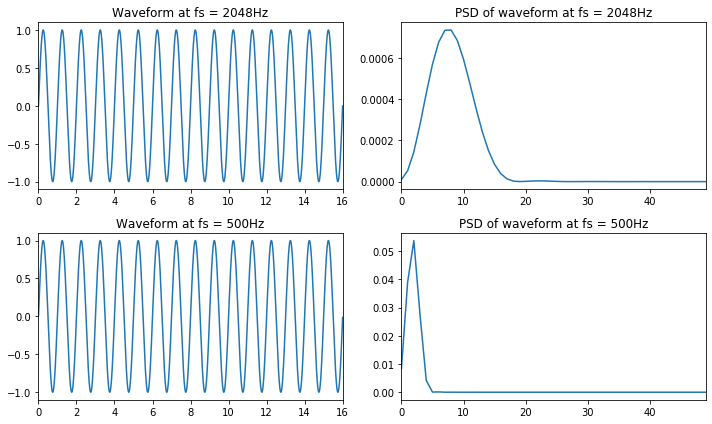

In [117]:
fig, axs = plt.subplots(2,2,figsize=(10,6))

fs = 2048
f = 1
x = np.arange(16*fs)
y = np.sin(2 * np.pi * f * (x / fs)) 
axs[0, 0].plot(x/2048, y)
axs[0, 0].set_xlim(0,16)
axs[0, 0].set_title('Waveform at fs = 2048Hz')

df_fft = get_freq(y, 2048)
df_fft = df_fft[df_fft['freq'] < 50]
axs[0, 1].plot(df_fft['freq'], df_fft['power'])
axs[0, 1].set_xlim(0,49)
axs[0, 1].set_title('PSD of waveform at fs = 2048Hz')

fs = 500
xt = x/2048
ts = 16
resampled = signal.resample(y, int(ts * fs))
resampled_time = np.linspace(0, 16, len(resampled))
axs[1, 0].plot(resampled_time, resampled)
axs[1, 0].set_xlim(0, 16)
axs[1, 0].set_title('Waveform at fs = 500Hz')

df_fft = get_freq(resampled, 500)
df_fft = df_fft[df_fft['freq'] < 50]
axs[1, 1].plot(df_fft['freq'], df_fft['power'])
axs[1, 1].set_xlim(0,49)
axs[1, 1].set_title('PSD of waveform at fs = 500Hz')
plt.tight_layout()

In [100]:
df1 = pd.read_excel('downsampling.xlsx', 0)
df2 = pd.read_excel('downsampling.xlsx', 1)

In [104]:
df2.head()

,1,0,0.1
0,2,0.000977,0.006136
1,3,0.001465,0.009204
2,4,0.001953,0.012272
3,5,0.002441,0.015339
4,6,0.002930,0.018407


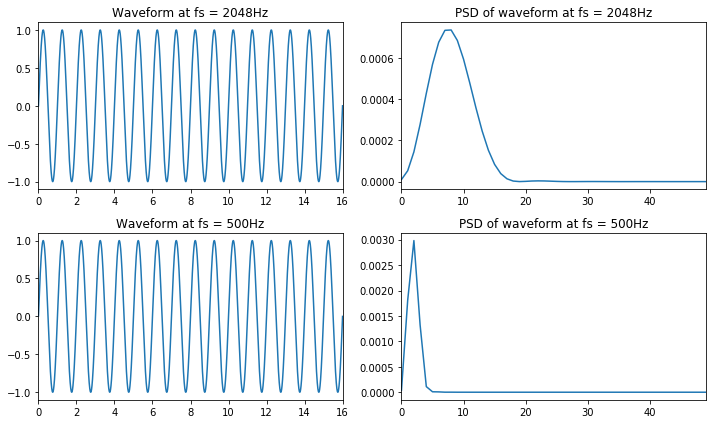

In [110]:
fig, axs = plt.subplots(2,2,figsize=(10,6))

axs[0, 0].plot(df1['time (s)'], df1['value'])
axs[0, 0].set_xlim(0,16)
axs[0, 0].set_title('Waveform at fs = 2048Hz')

df_fft = get_freq(df1['value'], 2048)
df_fft = df_fft[df_fft['freq'] < 50]
axs[0, 1].plot(df_fft['freq'], df_fft['power'])
axs[0, 1].set_xlim(0,49)
axs[0, 1].set_title('PSD of waveform at fs = 2048Hz')

axs[1, 0].plot(df2[0], df2['0.1'])
axs[1, 0].set_xlim(0, 16)
axs[1, 0].set_title('Waveform at fs = 500Hz')

df_fft = get_freq(df2['0.1'], 500)
df_fft = df_fft[df_fft['freq'] < 50]
axs[1, 1].plot(df_fft['freq'], df_fft['power'])
axs[1, 1].set_xlim(0,49)
axs[1, 1].set_title('PSD of waveform at fs = 500Hz')
plt.tight_layout()

# Compare PSDs of EEG

In [123]:
df1 = pd.read_excel('153-d1-power-long.xlsx')
df1['Dataset'] = 'Artifact removed + resampled'
df2 = pd.read_excel('158-d1-power-long.xlsx')
df2['Dataset'] = 'Artifact removed'
df3 = pd.read_excel('159-d1-power-long.xlsx')
df3['Dataset'] = 'None'
df4 = pd.read_excel('161-d1-power-long.xlsx')
df4['Dataset'] = 'Resampled'
df1 = pd.concat([df1, df2, df3, df4], axis=0)

In [124]:
print(df1.shape)
df1 = df1[df1['EEG'] == 'Raw']
print(df1.shape)
df1 = df1[df1['Method'] == 'Welch']
print(df1.shape)
df1 = df1[df1['Filter'] == 'Butterworth']
print(df1.shape)
# df1 = df1[df1['sub'] == sub]
# print(df1.shape)
# print(df1['Time'].unique())
df1 = df1[df1['Time'] == -750]
print(df1.shape)

(1541376, 15)
(513792, 15)
(171264, 15)
(85632, 15)
(42816, 15)


In [120]:
sub_map = {
    'sub01': 'Terry Baedon',
    'sub02': 'David Brown',
    'sub03': 'Sarah Brunet',
    'sub04': 'Lynette Gallaty',
    'sub05': 'Mana Higashihara',
    'sub06': 'Tim Howells',
    'sub07': 'Merolene Pirsarkiewicz',
    'sub08': 'Steve Vucic',
    'sub09': 'Hayeley Turnbull',
    'sub10': 'Nimeshan Geevasinga',
    'sub11': 'Amarissa M',
    'sub12': 'Marshall Owen',
    'sub13': 'Stephen Schebeci',
    'sub14': 'Matt Silsby',
    'sub15': 'Carlos Brito',
    'sub16': 'Alistair McEwan',
    'sub17': 'Toni Mathieson',
    'sub18': 'Karen Robertson',
    'sub19': 'Julie Terry',
    'sub20': 'Natalie Terry',
    'sub21': 'Raquib-ul Alam',
    'sub22': 'Lin Gavin',
}

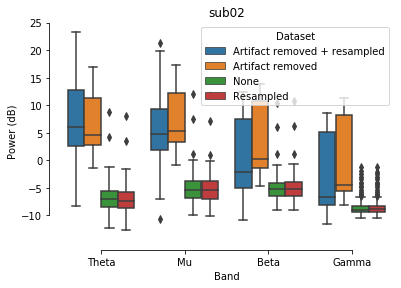

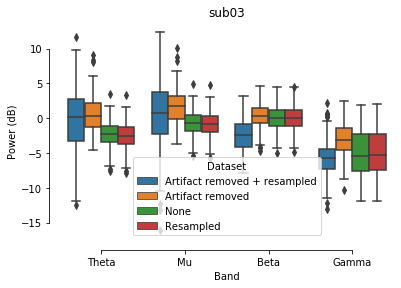

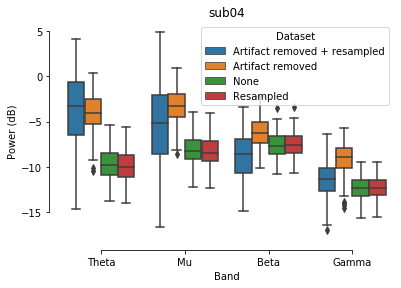

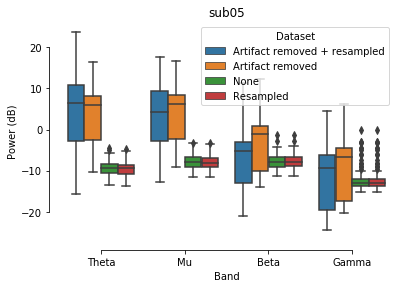

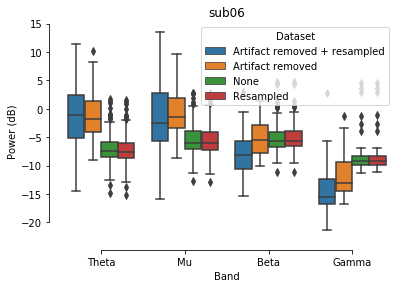

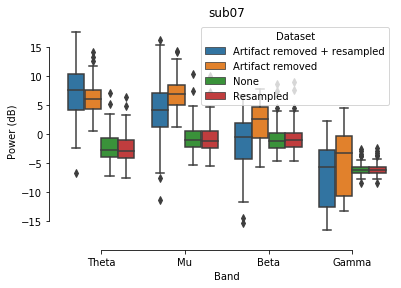

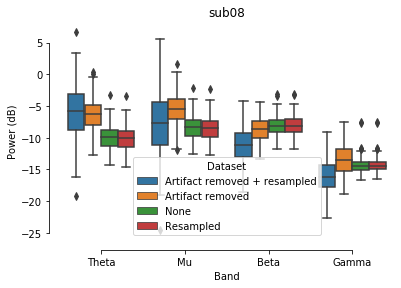

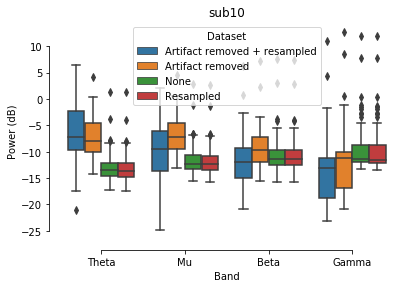

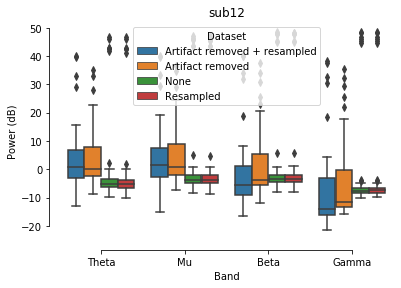

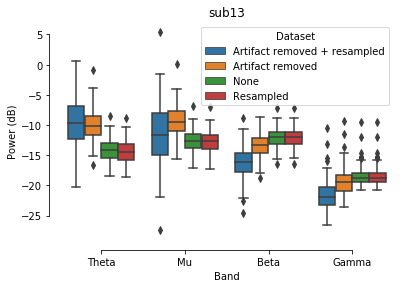

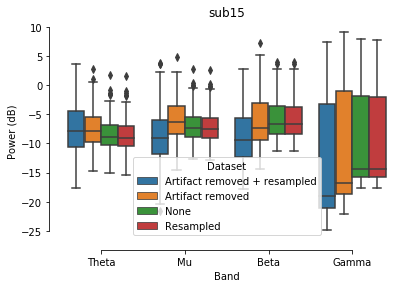

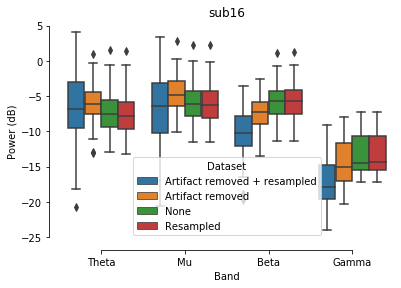

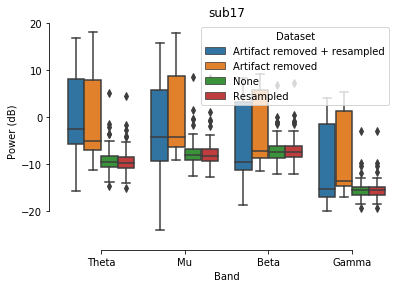

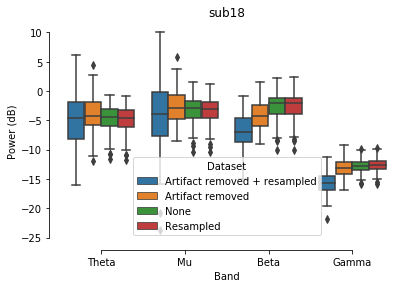

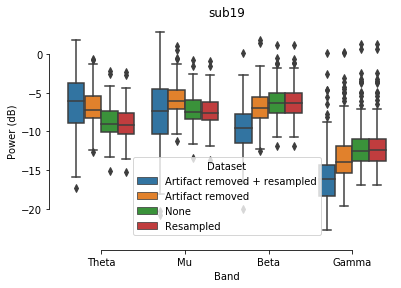

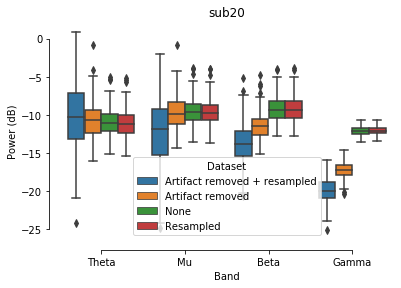

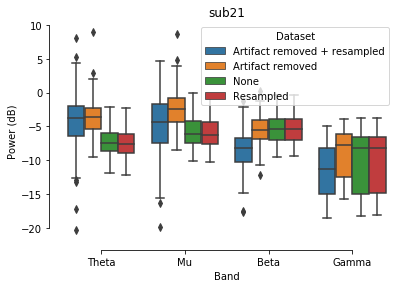

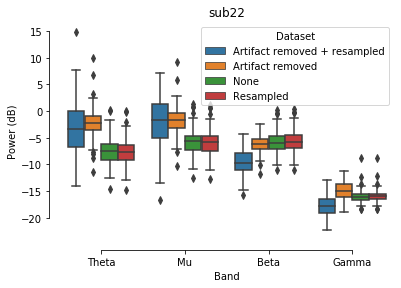

In [125]:
subs = df1['sub'].unique()
i = 1
for sub in tqdm(subs):
    plt.figure()
    df = df1[df1['EEG'] == 'Raw']
    df = df[df['Method'] == 'Welch']
    df = df[df['Filter'] == 'Butterworth']
    df = df[df['sub'] == sub]
    df = df[df['Time'] == -750]
    sns.boxplot(x="Band", y="value", hue='Dataset', data=df)
    sns.despine(offset=10, trim=True)
    plt.xlabel('Band')
    plt.ylabel('Power (dB)')
    plt.title(sub)
    plt.savefig('image-{}.jpg'.format(i))
    i = i + 1

In [ ]:
subs = df_combined['sub'].unique()
i = 1
for sub in tqdm(subs):
    plt.figure()
    df = df_combined[df_combined['Dataset'] == 'Without resampling']
    df = df[df['Method'] == 'Welch']
    df = df[df['Filter'] == 'Butterworth']
    df = df[df['sub'] == sub]
    df = df[df['Time'] == -750]
    sns.boxplot(x="Band", y="value", hue='EEG', data=df)
    sns.despine(offset=10, trim=True)
    plt.xlabel('Band')
    plt.ylabel('Power (dB)')
    plt.title("{} - {}".format(sub, sub_map[sub]))
#     plt.show()
    plt.savefig('image-{}.jpg'.format(i))
    i = i + 1